In [1]:
#pip install pandas-profiling[notebook,html]

In [2]:
import numpy as np
import pandas as pd
#from pandas_profiling import ProfileReport

In [3]:
churn_df = pd.read_csv(r'WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Comenzamos haciendo un analisis exploratorio univariado para detectar outliers, missing values y aspectos particulares de la distribución de cada variable

In [4]:
# profile = ProfileReport(churn_df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
# profile

In [5]:
# profile.to_file(r"C:\Users\mportuese\Documents\MICA\varios\AI\desafio1\telco-customer-churn\churn_df_inicial.html")

# Hay 21 variables: 13 categoricas, 6 booleanas y  con 7043 observaciones. Donde la variable target (churn) tiene una tasa de 26.5% (1869/7043)

# No se detectaron valores faltantes ni outliers pero encontramos que hay información repetida en distintas variables como es el caso de la categoría "no internet service", por lo tanto, al momento de contruir variables booleanas tendremos que tenerlo en cuenta para no duplicar información
Y que la variable TOTAL CHARGES esta definida como categorica ya que tiene espacios como valores posibles, sin embargo, es una variable continua.

In [6]:
#Transformación de datos

#Reemplazamos esos espacios con nulos

churn_df['TotalCharges'] = churn_df["TotalCharges"].replace(" ",np.nan)#transformamos TOTAL CHARGES a FLOAT 

#si vuelvo a analizar la variable ahora existen valores nulos en la variable TOTALCHARGES
churn_df.isnull().sum() 

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [7]:
#Eliminamos lo casos nulos 

churn_df = churn_df[churn_df["TotalCharges"].notnull()]
churn_df = churn_df.reset_index()[churn_df.columns]

#convierto la variable a numerica (float)

churn_df["TotalCharges"] = churn_df["TotalCharges"].astype(float)

In [8]:
#Continuación de tranformación de variables

#Ya tenemos la variable si tiene servicio de telefono o no,
#con lo cual podemos reemplazar en la variable MultipeLines la Categoria "No phone service" por "No"

churn_df['MultipleLines']  = churn_df['MultipleLines'].replace({'No phone service' : 'No'})
        

In [9]:
#Ya tenemos en InternetService la respuesta si el cliente no tiene el servicio,
#con lo cual podemos reemplazar en todas las variables donde dice "No internet service" por "No"

replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    churn_df[i]  = churn_df[i].replace({'No internet service' : 'No'})
    

In [10]:
# #Si vuelvo a analizar las correlaciones entre las variables aparece una leve correlación entre TotalCharges y MonthlyCharges,
# #y una alta correlacion entre tenure y TotalCharges

# profile = ProfileReport(churn_df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
# profile

In [11]:
# Con las variables continuas genero derivadas categoricas utilizando los deciles de su distribución.
# Si tuviera un nuevo dataset tendria que mantener los intervalos que definen los deciles definidos aqui
# para crear estas variables derivadas --> churn_df['tenure'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9])

churn_df['tenure_d'] = pd.qcut(churn_df['tenure'], 10, labels=False)
churn_df['MonthlyCharges_d'] = pd.qcut(churn_df['MonthlyCharges'], 10, labels=False)
churn_df['TotalCharges_d'] = pd.qcut(churn_df['TotalCharges'], 10, labels=False)


In [12]:
#Paso a booleanas todas las variables categoricas

#primero todas las que ya son booleanas y tienen valore "yes/no" a 1/0
replace_cols = [ 'Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies','PaperlessBilling','Churn']
for i in replace_cols : 
    churn_df[i]  = np.where(churn_df[i]=='Yes',1,0)

In [13]:
#transformo la variable Gender en 0/1
churn_df['gender']  = np.where(churn_df['gender']=='Female',1,0) 

In [14]:
#transformo la variable InternetService en dos booleanas
#para ver que categorias genero, previamente analizo la tasa de churn para cada una
pd.crosstab(churn_df.InternetService, churn_df.Churn), pd.crosstab(churn_df.InternetService, churn_df.Churn).apply(lambda r: r/r.sum(), axis=1)

(Churn               0     1
 InternetService            
 DSL              1957   459
 Fiber optic      1799  1297
 No               1407   113,
 Churn                   0         1
 InternetService                    
 DSL              0.810017  0.189983
 Fiber optic      0.581072  0.418928
 No               0.925658  0.074342)

In [15]:
#las categorias que mejor discriminan el churn seran las creadas
churn_df['DSL']  = np.where(churn_df['InternetService']=='DSL',1,0)
churn_df['NoInternetService']  = np.where(churn_df['InternetService']=='No',1,0)

In [16]:
#transformo la variable Contract en dos booleanas
#para ver que categorias genero, previamente analizo la tasa de churn para cada una
pd.crosstab(churn_df.Contract, churn_df.Churn), pd.crosstab(churn_df.Contract, churn_df.Churn).apply(lambda r: r/r.sum(), axis=1)

(Churn              0     1
 Contract                  
 Month-to-month  2220  1655
 One year        1306   166
 Two year        1637    48,
 Churn                  0         1
 Contract                          
 Month-to-month  0.572903  0.427097
 One year        0.887228  0.112772
 Two year        0.971513  0.028487)

In [17]:
#las categorias que mejor discriminan el churn seran las creadas

churn_df['OneyearContract']  = np.where(churn_df['Contract']=='One year',1,0)
churn_df['TwoyearContract']  = np.where(churn_df['Contract']=='Two year',1,0)

In [18]:
#transformo la variable PaymentMethod en dos booleanas
#para ver que categorias genero, previamente analizo la tasa de churn para cada una
pd.crosstab(churn_df.PaymentMethod, churn_df.Churn),pd.crosstab(churn_df.PaymentMethod, churn_df.Churn).apply(lambda r: r/r.sum(), axis=1)


(Churn                         0     1
 PaymentMethod                        
 Bank transfer (automatic)  1284   258
 Credit card (automatic)    1289   232
 Electronic check           1294  1071
 Mailed check               1296   308,
 Churn                             0         1
 PaymentMethod                                
 Bank transfer (automatic)  0.832685  0.167315
 Credit card (automatic)    0.847469  0.152531
 Electronic check           0.547146  0.452854
 Mailed check               0.807980  0.192020)

In [19]:
#las categorias que mejor discriminan el churn seran las creadas

churn_df['BanktransferPay']  = np.where(churn_df['PaymentMethod']=='Bank transfer (automatic)',1,0)
churn_df['CreditcardPay']  = np.where(churn_df['PaymentMethod']=='Credit card (automatic)',1,0)
churn_df['MailedcheckPay']  = np.where(churn_df['PaymentMethod']=='Mailed check',1,0)

In [20]:
churn_df['Cant_productos'] = churn_df['PhoneService'] + (1-churn_df['NoInternetService'])
churn_df['Cant_productos_internet'] = churn_df['OnlineSecurity'] + churn_df['OnlineBackup'] + \
                                      churn_df['DeviceProtection'] + churn_df['TechSupport'] + \
                                      churn_df['StreamingTV'] + churn_df['StreamingMovies'] 
churn_df['monthly_sobre_total'] = churn_df['MonthlyCharges'] / churn_df['TotalCharges']

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb


X_train, X_test, y_train, y_test = train_test_split(churn_df.drop(['customerID','Churn'],axis=1), churn_df[['Churn']], 
                                                    test_size=0.33, random_state=42)


In [22]:
#Normalizando variables continuas
from sklearn import preprocessing

x = X_train['tenure'].values.reshape(-1, 1) #returns a numpy array
std_scaler_tenure = preprocessing.StandardScaler()
x_scaled = std_scaler_tenure.fit_transform(x)
X_train['tenure_n'] = x_scaled

x = X_train['MonthlyCharges'].values.reshape(-1, 1) #returns a numpy array
std_scaler_MonthlyCharges = preprocessing.StandardScaler()
x_scaled = std_scaler_MonthlyCharges.fit_transform(x)
X_train['MonthlyCharges_n'] = x_scaled

x = X_train['TotalCharges'].values.reshape(-1, 1) #returns a numpy array
std_scaler_TotalCharges = preprocessing.StandardScaler()
x_scaled = std_scaler_TotalCharges.fit_transform(x)
X_train['TotalCharges_n'] = x_scaled

x = X_train['monthly_sobre_total'].values.reshape(-1, 1) #returns a numpy array
std_scaler_monthly_sobre_total = preprocessing.StandardScaler()
x_scaled = std_scaler_monthly_sobre_total.fit_transform(x)
X_train['monthly_sobre_total_n'] = x_scaled

x = X_test['tenure'].values.reshape(-1, 1) #returns a numpy array
x_scaled = std_scaler_tenure.transform(x)
X_test['tenure_n'] = x_scaled

x = X_test['MonthlyCharges'].values.reshape(-1, 1) #returns a numpy array
x_scaled = std_scaler_MonthlyCharges.transform(x)
X_test['MonthlyCharges_n'] = x_scaled

x = X_test['TotalCharges'].values.reshape(-1, 1) #returns a numpy array
x_scaled = std_scaler_TotalCharges.transform(x)
X_test['TotalCharges_n'] = x_scaled

x = X_test['monthly_sobre_total'].values.reshape(-1, 1) #returns a numpy array
x_scaled = std_scaler_monthly_sobre_total.transform(x)
X_test['monthly_sobre_total_n'] = x_scaled
 

In [23]:
X_train = X_train.drop(['tenure', 'MonthlyCharges', 'TotalCharges','InternetService','Contract','PaymentMethod'], axis=1)
X_test = X_test.drop(['tenure', 'MonthlyCharges', 'TotalCharges','InternetService','Contract','PaymentMethod'], axis=1)

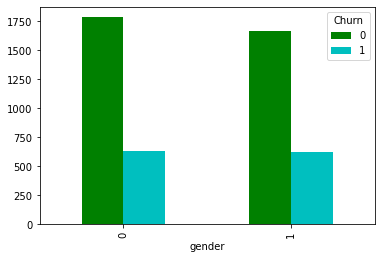

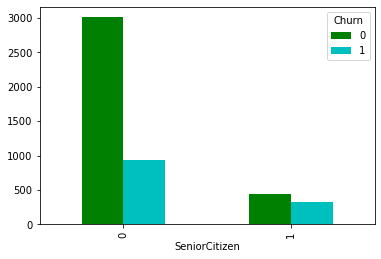

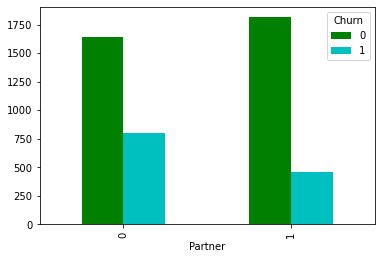

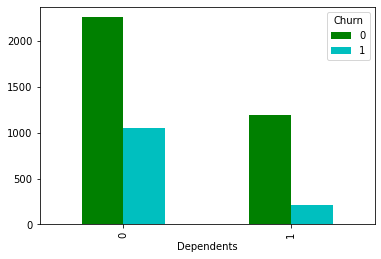

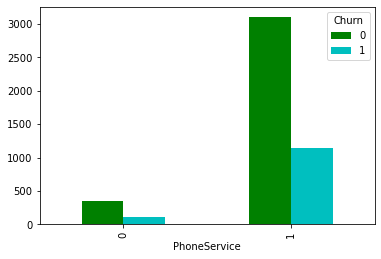

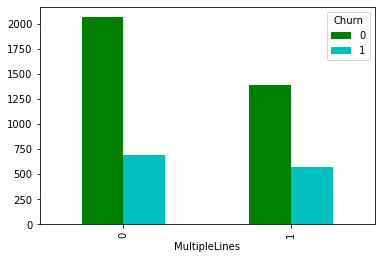

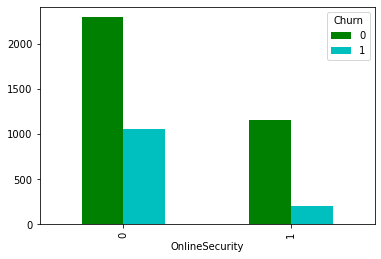

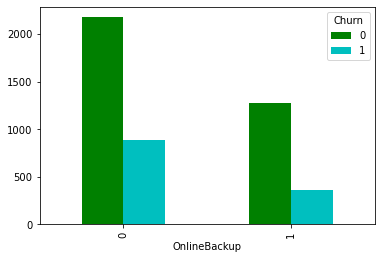

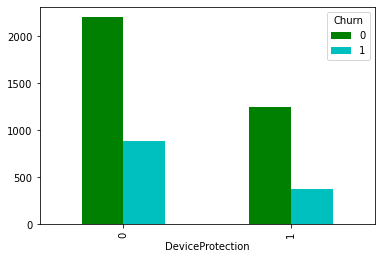

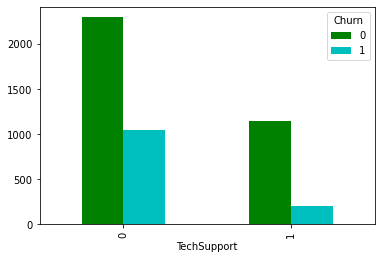

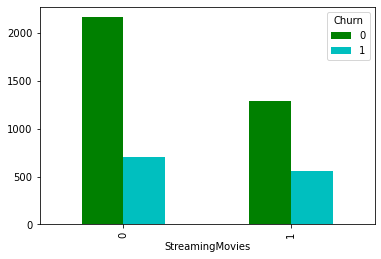

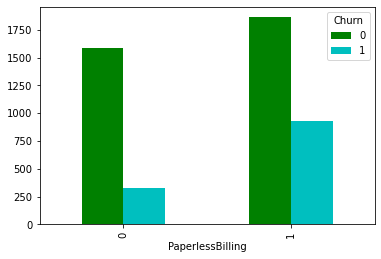

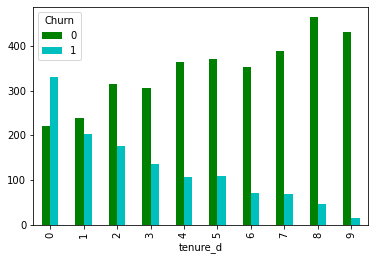

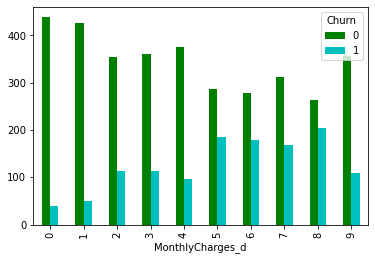

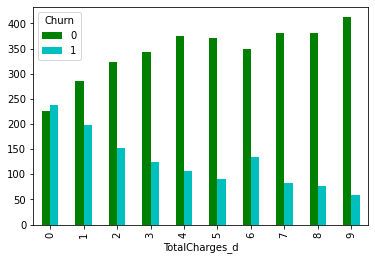

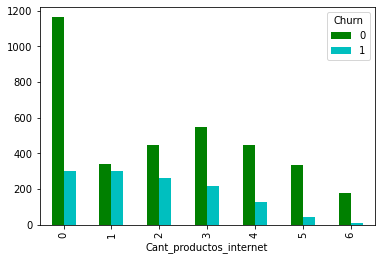

In [24]:
#Analisis bivariado
df_original = X_train.copy()
df_original['Churn'] = y_train.copy()
df_original.groupby(['gender','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
df_original.groupby(['SeniorCitizen','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
df_original.groupby(['Partner','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
df_original.groupby(['Dependents','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
df_original.groupby(['PhoneService','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
df_original.groupby(['MultipleLines','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
df_original.groupby(['OnlineSecurity','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
df_original.groupby(['OnlineBackup','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
df_original.groupby(['DeviceProtection','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
df_original.groupby(['TechSupport','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
df_original.groupby(['StreamingMovies','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
df_original.groupby(['PaperlessBilling','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
#df_original.groupby(['Contract','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
#df_original.groupby(['PaymentMethod','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
 
df_original.groupby(['tenure_d','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
df_original.groupby(['MonthlyCharges_d','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
df_original.groupby(['TotalCharges_d','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
 
#df.groupby(['Cant_productos','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
df_original.groupby(['Cant_productos_internet','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')
#df_original.groupby(['combo','Churn']).size().unstack().plot(kind='bar',stacked=False,color='g' 'c')

In [25]:
# df_original.to_csv('churn3.csv')

In [26]:
#armo las tablas para calcular los woe (ln(event/noevent))
#df_original.groupby(['tenure_d','Churn']).size().reset_index()
pd.crosstab(df_original.tenure_d, df_original.Churn),pd.crosstab(df_original.tenure_d, churn_df.Churn).apply(lambda r: r/r.sum(), axis=1)


(Churn       0    1
 tenure_d          
 0         221  330
 1         239  202
 2         315  176
 3         305  136
 4         364  106
 5         370  109
 6         354   70
 7         388   68
 8         464   47
 9         432   15,
 Churn            0         1
 tenure_d                    
 0         0.401089  0.598911
 1         0.541950  0.458050
 2         0.641548  0.358452
 3         0.691610  0.308390
 4         0.774468  0.225532
 5         0.772443  0.227557
 6         0.834906  0.165094
 7         0.850877  0.149123
 8         0.908023  0.091977
 9         0.966443  0.033557)

In [27]:
#armo las tablas para calcular los woe (ln(event/noevent))
#df_original.groupby(['MonthlyCharges_d','Churn']).size().reset_index()
pd.crosstab(df_original.MonthlyCharges_d, 
            df_original.Churn),
pd.crosstab(df_original.MonthlyCharges_d, 
            churn_df.Churn).apply(lambda r: r/r.sum(), axis=1)


(Churn               0    1
 MonthlyCharges_d          
 0                 438   40
 1                 426   49
 2                 354  114
 3                 360  114
 4                 375   96
 5                 287  185
 6                 278  179
 7                 313  168
 8                 264  205
 9                 357  109,
 Churn                    0         1
 MonthlyCharges_d                    
 0                 0.916318  0.083682
 1                 0.896842  0.103158
 2                 0.756410  0.243590
 3                 0.759494  0.240506
 4                 0.796178  0.203822
 5                 0.608051  0.391949
 6                 0.608315  0.391685
 7                 0.650728  0.349272
 8                 0.562900  0.437100
 9                 0.766094  0.233906)

In [28]:
#armo las tablas para calcular los woe (ln(event/noevent))
#df_original.groupby(['TotalCharges_d','Churn']).size().reset_index()
pd.crosstab(df_original.TotalCharges_d, df_original.Churn),pd.crosstab(df_original.TotalCharges_d, churn_df.Churn).apply(lambda r: r/r.sum(), axis=1)

(Churn             0    1
 TotalCharges_d          
 0               226  237
 1               285  197
 2               323  152
 3               344  124
 4               376  106
 5               372   91
 6               350  134
 7               382   82
 8               382   77
 9               412   59,
 Churn                  0         1
 TotalCharges_d                    
 0               0.488121  0.511879
 1               0.591286  0.408714
 2               0.680000  0.320000
 3               0.735043  0.264957
 4               0.780083  0.219917
 5               0.803456  0.196544
 6               0.723140  0.276860
 7               0.823276  0.176724
 8               0.832244  0.167756
 9               0.874735  0.125265)

In [29]:
#reagrupo la variable tenure en base al woe
conditions1 = [
    (df_original['tenure_d'] == 0),
    (df_original['tenure_d'] == 1),
    (df_original['tenure_d'] == 2),
    (df_original['tenure_d'] == 3),
    (df_original['tenure_d'] >= 4)  & (df_original['tenure_d'] <= 5),
    (df_original['tenure_d'] >= 6) & (df_original['tenure_d'] <= 7),
    (df_original['tenure_d'] == 8),
    (df_original['tenure_d'] == 9)]
choices1 = [0, 1, 2,3,4,5,6,7]
df_original['tenure_d2'] = np.select(conditions1, choices1, default=0)

In [30]:
#armo las tablas para calcular los woe (ln(event/noevent))
df_original.groupby(['tenure_d2','Churn']).size().reset_index()

,tenure_d2,Churn,0
0,0,0,221
1,0,1,330
2,1,0,239
3,1,1,202
4,2,0,315
5,2,1,176
6,3,0,305
7,3,1,136
8,4,0,734
9,4,1,215


In [31]:
#reagrupo la variable TotalCharges_d en base al woe
conditions2 = [
    (df_original['TotalCharges_d'] == 0),
    (df_original['TotalCharges_d'] == 1),
    (df_original['TotalCharges_d'] == 2),
    (df_original['TotalCharges_d'] == 3),
    (df_original['TotalCharges_d'] >= 4)  & (df_original['TotalCharges_d'] <= 5),
    (df_original['TotalCharges_d'] == 6),
    (df_original['TotalCharges_d'] >= 7) & (df_original['TotalCharges_d'] <= 8),
    (df_original['TotalCharges_d'] == 9)]
choices2 = [0, 1, 2,3,4,5,6,7]
df_original['TotalCharges_d2'] = np.select(conditions2, choices2, default=0)

In [32]:
#armo las tablas para calcular los woe (ln(event/noevent))
df_original.groupby(['TotalCharges_d2','Churn']).size().reset_index()

,TotalCharges_d2,Churn,0
0,0,0,226
1,0,1,237
2,1,0,285
3,1,1,197
4,2,0,323
5,2,1,152
6,3,0,344
7,3,1,124
8,4,0,748
9,4,1,197


In [33]:
#reagrupo la variable MonthlyCharges_d en base al woe
conditions3 = [
    (df_original['MonthlyCharges_d'] <2),
    (df_original['MonthlyCharges_d'] >= 2) & (df_original['MonthlyCharges_d'] <5 ),
    (df_original['MonthlyCharges_d'] >= 5) & (df_original['MonthlyCharges_d'] <9 ),
    (df_original['MonthlyCharges_d'] == 9)                                        ]
choices3 = [0, 1, 2,1]
df_original['MonthlyCharges_d2'] = np.select(conditions3, choices3, default=0)
print(df_original)

      gender  SeniorCitizen  Partner  Dependents  PhoneService  MultipleLines  \
5758       1              0        1           0             1              0   
5352       1              0        0           1             1              0   
5736       1              0        1           1             1              1   
6056       0              0        0           0             1              1   
229        1              0        1           1             1              1   
...      ...            ...      ...         ...           ...            ...   
3772       0              0        0           0             1              1   
5191       1              0        0           0             1              1   
5226       0              0        0           0             1              1   
5390       1              0        0           0             1              0   
860        0              1        1           0             1              0   

      OnlineSecurity  Onlin

In [34]:
#armo las tablas para calcular los woe (ln(event/noevent))
df_original.groupby(['MonthlyCharges_d2','Churn']).size().reset_index()

,MonthlyCharges_d2,Churn,0
0,0,0,864
1,0,1,89
2,1,0,1446
3,1,1,433
4,2,0,1142
5,2,1,737


In [35]:
df_original = pd.get_dummies(df_original, columns=['MonthlyCharges_d2'])

In [36]:
df_original = pd.get_dummies(df_original, columns=['TotalCharges_d2'])

In [37]:
df_original = pd.get_dummies(df_original, columns=['tenure_d2'])

In [38]:
df_original.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'tenure_d', 'MonthlyCharges_d', 'TotalCharges_d', 'DSL',
       'NoInternetService', 'OneyearContract', 'TwoyearContract',
       'BanktransferPay', 'CreditcardPay', 'MailedcheckPay', 'Cant_productos',
       'Cant_productos_internet', 'monthly_sobre_total', 'tenure_n',
       'MonthlyCharges_n', 'TotalCharges_n', 'monthly_sobre_total_n', 'Churn',
       'MonthlyCharges_d2_0', 'MonthlyCharges_d2_1', 'MonthlyCharges_d2_2',
       'TotalCharges_d2_0', 'TotalCharges_d2_1', 'TotalCharges_d2_2',
       'TotalCharges_d2_3', 'TotalCharges_d2_4', 'TotalCharges_d2_5',
       'TotalCharges_d2_6', 'TotalCharges_d2_7', 'tenure_d2_0', 'tenure_d2_1',
       'tenure_d2_2', 'tenure_d2_3', 'tenure_d2_4', 'tenure_d2_5',
       'tenure_d2_6', 'tenure_d2_7'],
      dtype='o

Accuracy en train 0.83
Accuracy en test 0.8


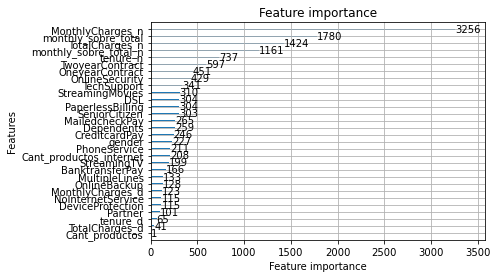

In [39]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, free_raw_data=False)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 15,
    'learning_rate': 0.005,
    'verbose_eval': -1
}
num_train, num_feature = X_train.shape
# generate feature names
feature_name = [str(col) for col in X_train.columns]
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_train,  # eval training data
                feature_name=feature_name,
                verbose_eval=False)

y_pred_train = gbm.predict(X_train)
y_pred_test = gbm.predict(X_test)

print("Accuracy en train", accuracy_score(y_train, y_pred_train.round()).round(2))
print("Accuracy en test", accuracy_score(y_test, y_pred_test.round()).round(2))
lgb.plot_importance(gbm)

In [40]:
X_train.shape

(4711, 30)

Primera capa: input_dim= X_train.shape[0]    30 neuronas
Capa oculta:  30 neuronas relu, y otra de 30 neuronas relu dropout
Capa de salida: 1 neurona "binary cross entropy" y "softmax" o "sigmoidea"

early stopping

In [59]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

network = Sequential() # Instanciamos un modelo secuencial

# Añadimos una capa oculta con 30 neuronas, con activación sigmoidea y cuyo input tiene 784 dimensiones
network.add(Dense(30, activation='relu', input_dim=X_train.shape[1])) 

# Añadimos una capa de salida con 10 neuronas, con activación sigmoidea
network.add(Dense(1, activation='sigmoid'))

network.compile(loss='binary_crossentropy',
                metrics=['accuracy'],
                optimizer='rmsprop')

In [60]:
network.fit(X_train, y_train,
            epochs=5, batch_size=16,
            validation_split=10000/X_train.shape[0])

Epoch 1/5
4711/4711 [==============================] - 1s 193us/step - loss: 0.5479 - accuracy: 0.7325
Epoch 2/5
4711/4711 [==============================] - 1s 170us/step - loss: 0.4429 - accuracy: 0.7862
Epoch 3/5
4711/4711 [==============================] - 1s 150us/step - loss: 0.4292 - accuracy: 0.7945
Epoch 4/5
4711/4711 [==============================] - 1s 150us/step - loss: 0.4242 - accuracy: 0.7992
Epoch 5/5
4711/4711 [==============================] - 1s 139us/step - loss: 0.4182 - accuracy: 0.8047


In [61]:
# evaluate() devuelve los valores de la loss y las métricas definidas en la compilación
test_loss, test_acc = network.evaluate(X_test, y_test)
train_loss, train_acc = network.evaluate(X_train, y_train)

4711/4711 [==============================] - 0s 44us/step


In [62]:
# Llamando al atributo metric_names podemos ver las métricas del modelo, que son el output del método evaluate()
network.metrics_names

['loss', 'accuracy']

In [63]:
print('train_acc:', train_acc)
print('train_loss:', train_loss)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

train_acc: 0.8070473074913025
train_loss: 0.40726751204231343
test_acc: 0.7979319095611572
test_loss: 0.4204871782785035
